## map2loop: From geology layers to outputs to various 3D modelling programs- Hamersley example (LoopStructural)

This notebook reads in three layers from  local or remote sources:  geology polygons, orientation data and fault polylines; and calculates the topological relationships between the different features. Requires compiled cpp code from Vitaliy Ogarko

This all gets fed into successive tolopogical and geometric transfroms that end up feeding into geomodeller to make a 3D model 
<img src='../graphics/map_sm.png'>

## 1a Load libraries and test GDAL path

In [26]:
import geopandas as gpd
import pandas as pd
import numpy as np
import os
import sys
import stat
import functools 
import operator  
import matplotlib
import networkx as nx
import rasterio
from shapely.geometry import Polygon
from map2loop import m2l_utils
from map2loop import m2l_topology
from map2loop import m2l_geometry
from map2loop import m2l_interpolation
from map2loop import m2l_export
import time
%matplotlib inline
t0 = time.time()

#newwd="C:\\Users\\00073294\Dropbox\\loop_minex\\map2model\\"
#os.chdir(newwd)
print("Current Working Directory " )

gdal_data = os.environ['GDAL_DATA']
print("***",gdal_data)
print('is dir: ' + str(os.path.isdir(gdal_data)))
gcs_csv = os.path.join(gdal_data, 'gcs.csv')
print('is file: ' + str(os.path.isfile(gcs_csv)))
st = os.stat(gcs_csv)
print('is readable: ' + str(bool(st.st_mode & stat.S_IRGRP)))
os.environ['PROJ_LIB']=r"C:\\Users\\00073294\\AppData\\Local\\Continuum\\anaconda3\\Lib\\site-packages\\pyproj\\proj_dir\\share\\proj"
print(os.getenv('PROJ_LIB'))
print(os.getcwd())


Current Working Directory 
*** C:\Program Files\PostgreSQL\11\gdal-data
is dir: True
is file: True
is readable: True
C:\\Users\\00073294\\AppData\\Local\\Continuum\\anaconda3\\Lib\\site-packages\\pyproj\\proj_dir\\share\\proj
C:\Users\00073294\Dropbox\1_Jupyter_notebooks\map2loop\map2loop


## 1b Load config file and Create bounding box based on inputs 

In [27]:
test_data_name='test_data3'

test_data_path='../'+test_data_name+'/'

os.chdir(test_data_path)
%run -i "m2l_config.py"
#%run -i "m2l_config_remote.py"
print(os.getcwd())

bbox2=str(minx)+","+str(miny)+","+str(maxx)+","+str(maxy)
lat_point_list = [miny, miny, maxy, maxy, maxy]
lon_point_list = [minx, maxx, maxx, minx, minx]
bbox_geom = Polygon(zip(lon_point_list, lat_point_list))
polygon = gpd.GeoDataFrame(index=[0], crs=dst_crs, geometry=[bbox_geom]) 
bbox=(minx,miny,maxx,maxy)


Default parameters loaded from ../test_data3/m2l_config.py:
#ROI

step_out=0.1   #padding arounf dtm to ensure reprojected dtm covers target area (in degrees)
inset=0      #unused??

minx=500057  #region of interest coordinates in metre-based system (or non-degree system)
maxx=603028
miny=7455348
maxy=7567953
model_top=1200
model_base=-8200

#PATHS

local_paths=True       #flag to use local or WFS source for data inputs (True = local)

test_data_path='../test_data3/'

geology_file='hams2_geol.shp'   #input geology file (if local)
fault_file='GEOS_GEOLOGY_LINEARSTRUCTURE_500K_GSD.shp' #input fault file (if local)
structure_file='hams2_structure.shp' #input bedding orientation file (if local)
mindep_file='mindeps_2018.shp' #input mineral deposit file (if local)

#CRS

src_crs = {'init': 'EPSG:4326'}  # coordinate reference system for imported dtms (geodetic lat/long WGS84)
dst_crs = {'init': 'EPSG:28350'} # coordinate system for data

#CODES AND LABELS 
# these refer to specific fields (

In [28]:
#local_paths=False
fold_decimate=2         

contact_decimate=5

use_interpolations=True       #use interpolated dips/contacts as additional constraints

use_fat=True                   #use fold axial trace orientation hints

pluton_form='domes'

fault_dip=-999

min_fault_length=5000

compute_etc=False

#################################
# There are many alternative datasets that can be extracted from the input data, 
# and many choices of possible input data
#
# These flags define what the actual workflow will be for this experiment
#################################
workflow={'seismic_section':False,
          'map':True,
          'cover_map':False,
          'near_fault_interpolations':True,
          'fold_axial_traces':False,
          'stereonets':True,
          'formation_thickness':False,
          'get_remote_dtm':False,
          'fault_offset':False}

# no cover info so no need load cover layers
cover_map=False
dtb=0
dtb_null=0

## 1c First we test to see if we have access to the online data we need


In [29]:
loopwfs=m2l_utils.have_access("geo.loop-gis.org")
hawaii=m2l_utils.have_access("services.ga.gov.au")

if(not (loopwfs & hawaii)):
    local_paths=True
    net=False
    print('using local paths')
else:
    net=True

available: geo.loop-gis.org
available: services.ga.gov.au


## 1d Optional WFS source
  
WFS brings in field names as lower case, so need to redefine codes too

In [30]:
if((not local_paths) and net):
    structure_file='http://geo.loop-gis.org/geoserver/loop/wfs?service=WFS&version=1.1.0&request=GetFeature&typeName=warox_points_f5011&bbox='+bbox2+'&srs=EPSG:28350'
    fault_file='http://geo.loop-gis.org/geoserver/loop/wfs?service=WFS&version=1.1.0&request=GetFeature&typeName=linear_500k&bbox='+bbox2+'&srs=EPSG:28350'
    geology_file='http://geo.loop-gis.org/geoserver/loop/wfs?service=WFS&version=1.0.0&request=GetFeature&typeName=loop:geol_500k&bbox='+bbox2+'&srs=EPSG:28350'

    c_l= {
    #Orientations
      "d": "dip",                  #field that contains dip information
      "dd": "dip_dir",             #field that contains dip direction information
      "sf": 'feature',             #field that contains information on type of structure
      "bedding": 'Bed',            #text to search for in field defined by sfcode to show that this is a bedding measurement
      "otype": 'strike',            #flag to determine measurement convention (currently 'strike' or 'dip direction')
    #Stratigraphy
      "g": 'group_',               #field that contains coarser stratigraphic coding
      "c": 'code',                 #field that contains finer stratigraphic coding
      "ds": 'descriptn',           #field that contains information about lithology
      "u": 'unitname',             #field that contains alternate stratigraphic coding (not used??)
      "r1": 'rocktype1',           #field that contains  extra lithology information
      "r2": 'rocktype2',           #field that contains even more lithology information
      "sill": 'sill',              #text to search for in field defined by dscode to show that this is a sill
      "intrusive": 'intrusive',    #text to search for in field defined by dscode to show that this is an intrusion
      "volcanic": 'volcanic',      #text to search for in field defined by dscode to show that this is an intrusion
    #Mineral Deposits
      "msc": 'SITE_CODE',          #field that contains site code of deposit
      "msn": 'SHORT_NAME',         #field that contains short name of deposit
      "mst": 'SITE_TYPE_',         #field that contains site type of deposit
      "mtc": 'TARGET_COM',         #field that contains target commodity of deposit
      "mscm": 'SITE_COMMO',        #field that contains site commodity of deposit
      "mcom": 'COMMODITY_',        #field that contains commodity group of deposit
      "minf": 'Infrastructure',    #text to search for in field defined by mst code that shows site to ignore
    #Timing
      "min": 'min_age_ma',         #field that contains minimum age of unit defined by ccode
      "max": 'max_age_ma',         #field that contains maximum age of unit defined by ccode
    #faults and folds
      "f": 'feature',              #field that contains information on type of structure
      "fault": 'Fault',            #text to search for in field defined by fcode to show that this is a fault
      "fold": 'Fold axial trace',  #text to search for in field defined by fcode to show that this is a fold axial trace
      "n": 'name',                 #field that contains information on name of fault (not used??)
      "t": 'type',                 #field that contains information on type of fold
      "syn": 'syncline',           #text to search for in field defined by t to show that this is a syncline
    #ids
      "o": 'objectid',             #field that contains unique id of geometry object
      "gi": 'geopnt_id'            #field that contains unique id of structure point
    }

## 1e Plot geology polygons and bounding box

../test_data3/data/hams2_geol.shp


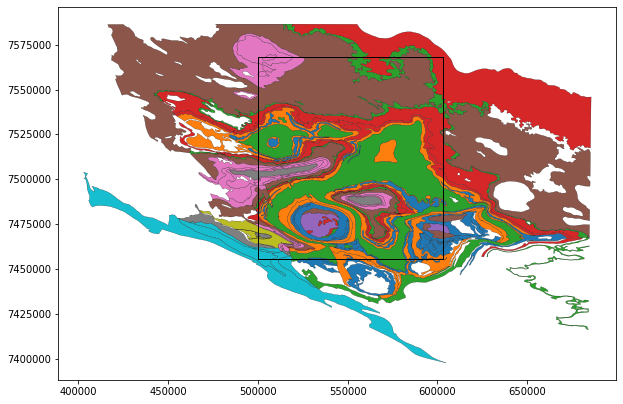

In [31]:
print(geology_file)
geology_ll = gpd.read_file(geology_file,bbox=bbox)

base=geology_ll.plot(column=c_l['c'],figsize=(10,10),edgecolor='#000000',linewidth=0.2)
polygon.plot(ax=base, color='none',edgecolor='black')


## 1f Save geology to file as WKT

In [32]:
hint_flag=True # use GSWA strat database to provide relative age hints
sub_geol = geology_ll[['geometry', c_l['o'],c_l['c'],c_l['g'],c_l['u'],c_l['min'],c_l['max'],c_l['ds'],c_l['r1'],c_l['r2']]]
m2l_topology.save_geol_wkt(sub_geol,geology_file_csv, c_l,hint_flag)

Using ENS age hints
186  polygons


## 1g1 Save mineral deposits to file as WKT
This is not needed by map2loop to build 3D models, but is used by map2model to calculate mineral deposit/topology analyses.

410  points


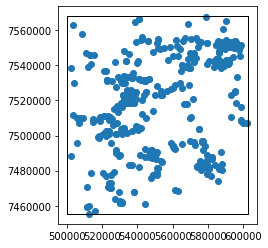

In [33]:
mindep = gpd.read_file(mindep_file,bbox=bbox)

sub_mindep = mindep[['geometry', c_l['msc'],c_l['msn'],c_l['mst'],c_l['mtc'],c_l['mscm'],c_l['mcom']]]
m2l_topology.save_mindep_wkt(sub_mindep,mindep_file_csv, c_l)

base=sub_mindep.plot()
polygon.plot(ax=base, color='none',edgecolor='black')


## 1g2 Read and save WAROX point data as WKT

121  points


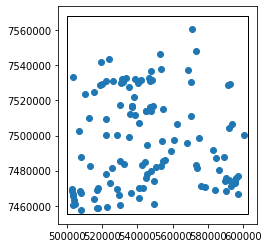

In [34]:
warox = gpd.read_file(structure_file,bbox=bbox)

sub_pts = warox[['geometry', c_l['gi'],c_l['d'],c_l['dd']]]

m2l_topology.save_structure_wkt(sub_pts,structure_file_csv,c_l)

base=sub_pts.plot()
polygon.plot(ax=base, color='none',edgecolor='black')


## 1h Plot faults and fold axial traces and bounding box

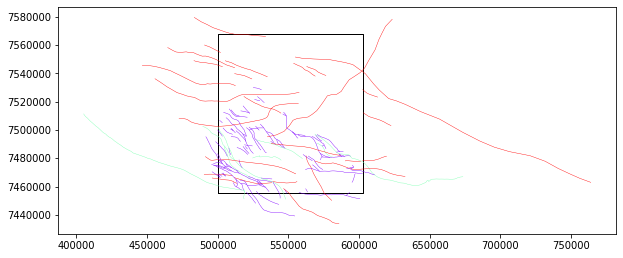

In [35]:
lines_ll=gpd.read_file(fault_file,bbox=bbox)

base2=lines_ll.plot(cmap='rainbow',column=c_l['f'],figsize=(10,10),linewidth=0.4)
polygon.plot(ax=base2, color='none',edgecolor='black')


## 1i Save faults to file as WKT

In [36]:
sub_lines = lines_ll[['geometry', c_l['o'],c_l['f']]]
m2l_topology.save_faults_wkt(sub_lines,fault_file_csv,c_l)

134  polylines


## 1j Create map2model input file

In [37]:
m2l_topology.save_Parfile(m2m_cpp_path,c_l,graph_path,geology_file_csv,fault_file_csv,structure_file_csv,mindep_file_csv,minx,maxx,miny,maxy,500.0,'Fe,Cu,Au,NONE')


## 1k Calculate topology

In [38]:
import subprocess
import platform

os.chdir(m2m_cpp_path)
print(os.getcwd())

#%system ./map2model Parfile
if(platform.system()=='Windows'):
    subprocess.run(["map2model.exe","Parfile"],capture_output=True)
else:
    subprocess.run(["./map2model","Parfile"],capture_output=True)
    

C:\Users\00073294\Dropbox\1_Jupyter_notebooks\map2loop\m2m_cpp


## 1l Simple network graph of the geology with legend

0    'A-HAm-cib'
1    'A-FOp-bs'
2    'A-HAS-xsl-ci'
3    'P_-HAb-cib'
4    'P_-HAj-xci-od'
5    'A-mgn-PRK'
6    'A-FOh-xs-f'
7    'A-FOo-bbo'
8    'A-FO-od'
9    'A-HAd-kd'
10    'A-FOj-xs-b'
11    'P_-TKa-xs-k'
12    'P_-HAo-ci'
13    'P_-HAw-fr'
14    'A-FO-xo-a'
15    'A-b-PRK'
16    'A-FOr-b'
17    'A-FOu-bbo'
18    'P_-TK-s'
19    'A-mgn-PMI'
20    'A-s-PMI'
21    'A-s-PRK'
22    'P_-SKq-stq'
23    'P_-WYm-sp'
24    'P_-WYa-st'
25    'P_-WYd-kd'
26    'P_-TKo-stq'
27    'P_-TKk-sf'
28    'P_-SKb-bb'


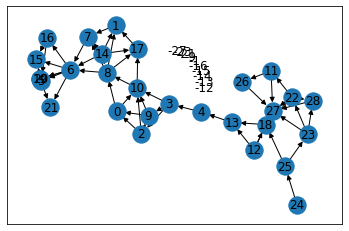

In [39]:
G=nx.read_gml(strat_graph_file,label='id')
selected_nodes = [n for n,v in G.nodes(data=True) if n >=0]
nx.draw_networkx(G, pos=nx.kamada_kawai_layout(G), arrows=True, nodelist=selected_nodes)

nlist=list(G.nodes.data('LabelGraphics'))
nlist.sort()
for no in nlist:
    if(no[0]>=0):
        elem=str(no[1]).replace("{'text':","").replace(", 'fontSize': 14}","")
        #second=elem.split(":").replace("'","")
        print(no[0]," ",elem)

## 2a Process topography, stratigraphy, fold axial traces and faults

### Takes GML file produced by topology code, combines with geology polygons, structure points and dtm to create 3D model in gempy.<br><br>

Limitations:  no dykes, no sills. Sills require us to assign a unique surface to each instance of a sill (sill between units A and B needs to be different from sill of same age and strat codes as one found between E and F). Dykes via cokriging are really hard without just cookie cutting them in (but that is not our problem!). We are not checking for onlap relationships, which can perhaps been seen by having lots of units from one series adjacent to the youngest surface of the older series. Could also think about interpreting these as faults to introduce conceptual uncertainty. All mistakes belong to Mark Jessell, topology code that feeds this system by Vitaliy Ogarko.<br><br>

Geology layer needs to have some unique strat code or text, some group code or text to function<br>
Structure layer needs dip/dip direction<br>

<font color='red'>Currently mostly hardwired to GSWA 500K map so needs work...</font>


In [40]:
os.chdir('../map2loop')

print(os.getcwd())

C:\Users\00073294\Dropbox\1_Jupyter_notebooks\map2loop\map2loop


In [41]:
#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:80% !important; }</style>"))

sys.path.insert(0,"../..")
print(os.getcwd())


#print(os.getcwd())
#os.environ["PROJ_LIB"] = r"C:\Users\00073294\AppData\Local\Continuum\anaconda3\Lib\site-packages\pyproj\proj_dir\share\proj"


C:\Users\00073294\Dropbox\1_Jupyter_notebooks\map2loop\map2loop


## 2b Next we define an area of interest and some other basic stuff

In [42]:
print(os.getcwd())
#test_data_path='../test_data3/'


#%run -i "../test_data3/m2l_config.py"

bbox2=str(minx)+","+str(miny)+","+str(maxx)+","+str(maxy)
lat_point_list = [miny, miny, maxy, maxy, maxy]
lon_point_list = [minx, maxx, maxx, minx, minx]
bbox_geom = Polygon(zip(lon_point_list, lat_point_list))
polygon = gpd.GeoDataFrame(index=[0], crs=dst_crs, geometry=[bbox_geom]) 
bbox=(minx,miny,maxx,maxy)

step_out=0.045 #add (in degrees) so edge pixel from dtm reprojection are not found


#contact_decimate=5

C:\Users\00073294\Dropbox\1_Jupyter_notebooks\map2loop\map2loop


## 2c Download and reproject the appropriate SRTM data
mj: Getting this from GA, but could also get from Hawaii

In [43]:
polygon_ll=polygon.to_crs(src_crs)

minlong=polygon_ll.total_bounds[0]-step_out
maxlong=polygon_ll.total_bounds[2]+step_out
minlat=polygon_ll.total_bounds[1]-step_out
maxlat=polygon_ll.total_bounds[3]+step_out

print(minlong,maxlong,minlat,maxlat)
if((not local_paths) and net):     
    m2l_utils.get_dtm(dtm_file, minlong,maxlong,minlat,maxlat)
    geom_rp=m2l_utils.reproject_dtm(dtm_file,dtm_reproj_file,src_crs,dst_crs)



116.9555521867685 118.0503484485386 -23.055227990891293 -21.94491765252865


## 2d Load stratigraphy graph and create list of series (aka groups)
mj: The choice of what constitutes basic unit and what a group of units is hard-wired at the moment, but could be altered to any pair. Not even sure we need two levels but it seemed like a good idea at the time. Note that this needs the arcgis plugin version of the topology code (for now) as it seperates the different sub graphs. Text outputs list alternate topologies for series and surfaces, which if confirmed by comapring max-min ages will be a nice source of uncertainty.

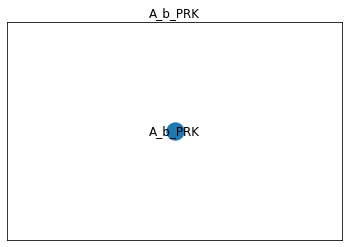

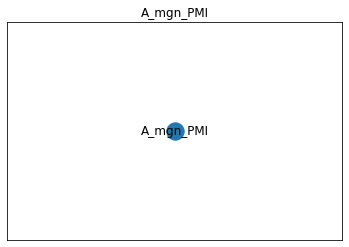

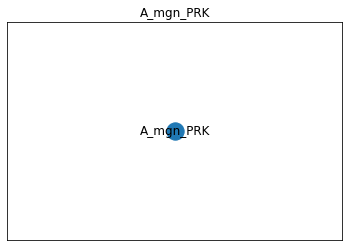

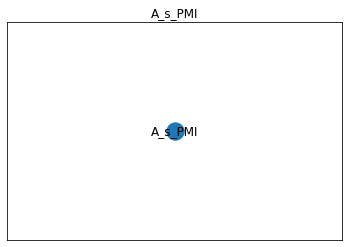

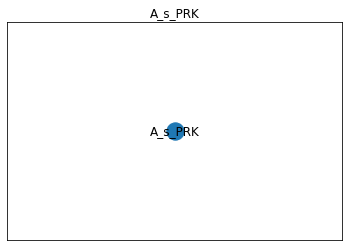

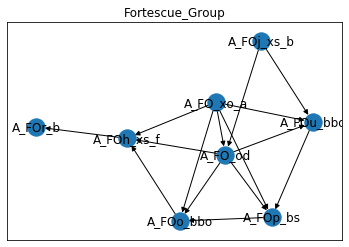

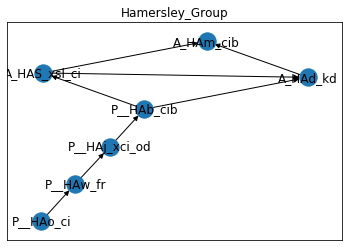

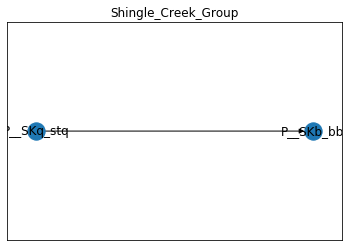

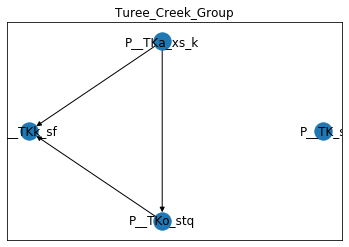

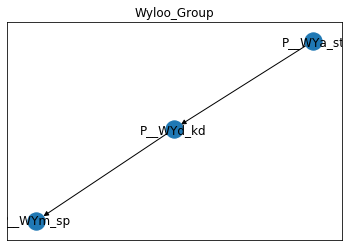

In [44]:
groups,glabels,G = m2l_topology.get_series(strat_graph_file,'id')
m2l_topology.save_units(G,tmp_path,glabels)

## 2e Load geology & structure data
Currently loading from local files, but could load geology from WFS server at GSWA EXCEPT that the WFS online map has less fields that the zipped shapefiles. Go figure. We don't use fault layer at the moment (except for Vitaliy's topology code) but same logic applies in terms of where to get it from. Already have fault/strat relationships and once we have fault/fault relationships will start to include faults in models.

../test_data3/data/GEOS_GEOLOGY_LINEARSTRUCTURE_500K_GSD.shp


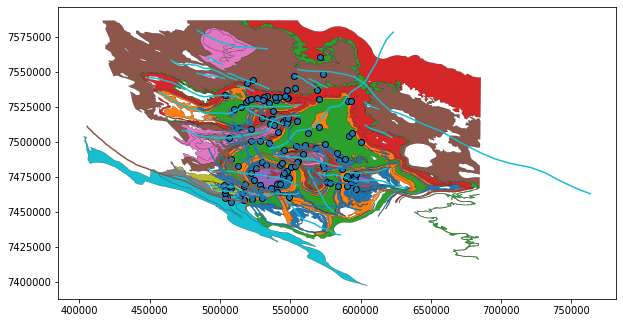

In [45]:
# Extract point data from structure & geology layers for modelling
##First we readin the structure and map from shapefiles, or wherever...

bbox=(minx,miny,maxx,maxy)
geology = gpd.read_file(geology_file,bbox=bbox)


structure = gpd.read_file(structure_file,bbox=bbox)
structure.crs=dst_crs
print(fault_file)
faults = gpd.read_file(fault_file,bbox=bbox)
faults.crs=dst_crs
#display(faults)
sub_pts = structure[['geometry',c_l['d'],c_l['dd'],c_l['sf']]] 

base=geology.plot(column=c_l['c'],figsize=(10,10),edgecolor='#000000',linewidth=0.2)
sub_pts.plot(ax=base,edgecolor='black')
faults.plot(ax=base, column=c_l['f'],edgecolor='black')

## 2f Clip geology, faults, structures and map geology to structures

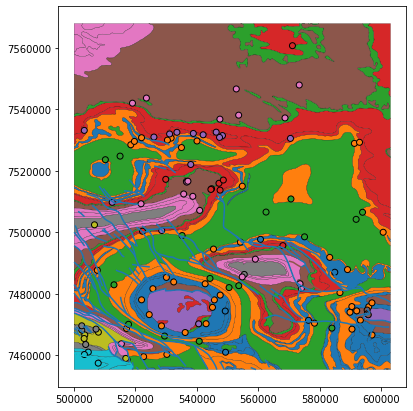

In [46]:
geology = m2l_utils.explode(geology)
geology.crs = dst_crs
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',None)
structure_code = gpd.sjoin(sub_pts, geology, how="left", op="within")

y_point_list = [miny, miny, maxy, maxy, miny]
x_point_list = [minx, maxx, maxx, minx, minx]

bbox_geom = Polygon(zip(x_point_list, y_point_list))

polygo = gpd.GeoDataFrame(index=[0], crs=dst_crs, geometry=[bbox_geom]) 
#display(polygo.geometry)
is_bed=structure_code[c_l['sf']].str.contains(c_l['bedding'], regex=False) 
    
all_beds = structure_code[is_bed]
#display(sfcode)
all_folds=faults[faults[c_l['f']].str.contains(c_l['fold'])]
folds_clip=m2l_utils.clip_shp(all_folds,polygo)
folds_clip.to_file(tmp_path+'folds_clip.shp')


all_faults=faults[faults[c_l['f']].str.contains(c_l['fault'])]



#display(structure_code)
#geol_clip=m2l_utils.clip_shp(geology, polygo)
geol_clip=gpd.overlay(geology, polygo, how='intersection')
faults_clip=m2l_utils.clip_shp(all_faults,polygo)
#display(faults_clip)
structure_clip = m2l_utils.clip_shp(all_beds, polygo)

base = geol_clip.plot(column=c_l['c'],figsize=(7,7),edgecolor='#000000',linewidth=0.2)
faults_clip.plot(ax=base, column=c_l['t'],edgecolor='black')
structure_clip.plot(ax=base, column=c_l['c'],edgecolor='black')

geol_clip.to_file(tmp_path+'geol_clip.shp')
faults_clip.to_file(tmp_path+'faults_clip.shp')
structure_clip.to_file(tmp_path+'structure_clip.shp')


## 2g Create possible stratigraphy sets per group
mj: <font color='red'>Uses first of each possible set of toplogies per unit and per group, which is arbitrary. </font>On the other hand we are not checking relative ages again to see if this helps reduce ambiguity, which I think it would.

,index,min,max,ave
group_,,,,
Wyloo_Group,0,1799.0,2010.0,1904.5
Shingle_Creek_Group,1,2208.0,2208.0,2208.0
Turee_Creek_Group,2,2208.0,2449.0,2328.5
Hamersley_Group,3,2208.0,2629.0,2418.5
Fortescue_Group,4,2629.0,2780.0,2704.5
A_mgn_PRK,5,2830.0,3500.0,3165.0
A_mgn_PMI,6,2830.0,3500.0,3165.0
A_b_PRK,7,2930.0,3520.0,3225.0
A_s_PMI,8,2930.0,3520.0,3225.0


[]

group choices: 40


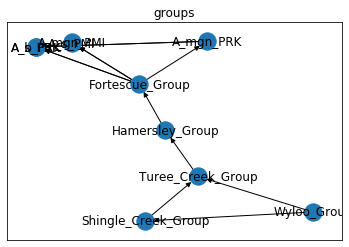

In [47]:
m2l_topology.save_group(G,tmp_path,glabels,geol_clip,c_l)

## 3a Export orientation data in csv  format
mj: Orientation data needs calculated height as file does not provide it, taken from SRTM data already downloaded. To calculate polarity see Cell 6b below for test implementation) 

Added code to not save intrusion orientation data as they won't have associated surfaces if sill...

115 orientations saved to ../test_data3/output/orientations.csv


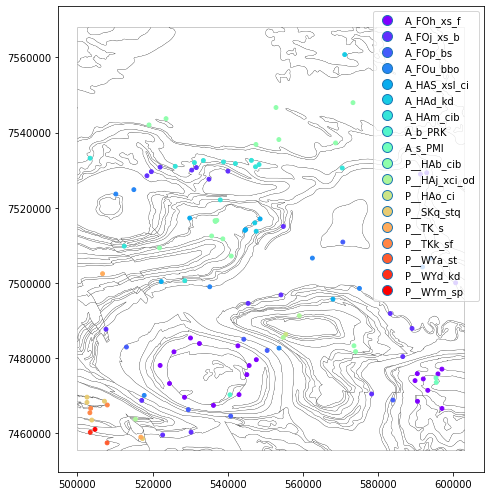

In [48]:
dtm = rasterio.open(dtm_reproj_file)
m2l_geometry.save_orientations(structure_code,output_path,c_l,orientation_decimate,dtm,dtb,dtb_null,cover_map)
m2l_utils.plot_points(output_path+'orientations.csv',geol_clip, 'formation','X','Y',True)

##  Display stereonets of bedding by formations and group to see how we can combine them later

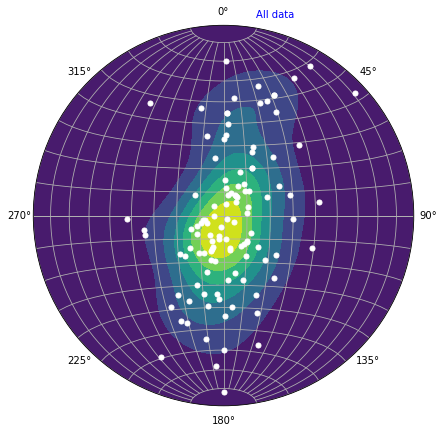

----------------------------------------------------------------------------------------------------------------------
Wyloo_Group observations n= 3


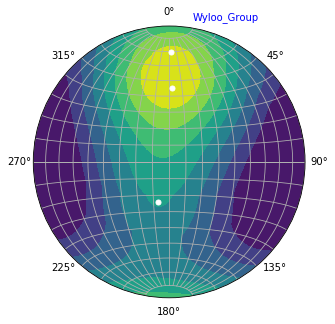

----------------------------------------------------------------------------------------------------------------------
Shingle_Creek_Group observations n= 5


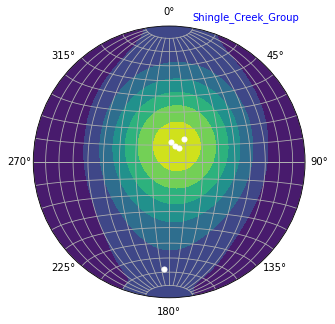

----------------------------------------------------------------------------------------------------------------------
Turee_Creek_Group observations n= 5


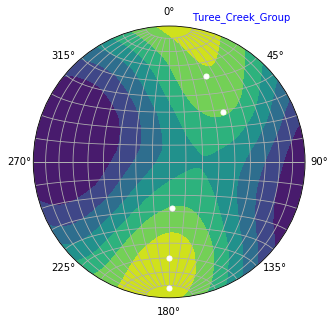

----------------------------------------------------------------------------------------------------------------------
Hamersley_Group observations n= 42


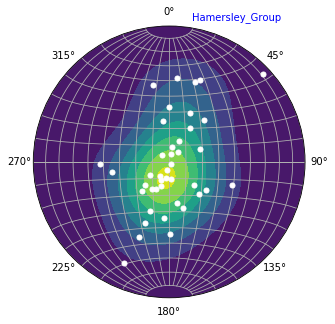

----------------------------------------------------------------------------------------------------------------------
Fortescue_Group observations n= 57


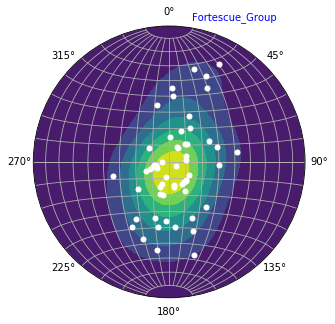

----------------------------------------------------------------------------------------------------------------------
A_s_PMI observations n= 2


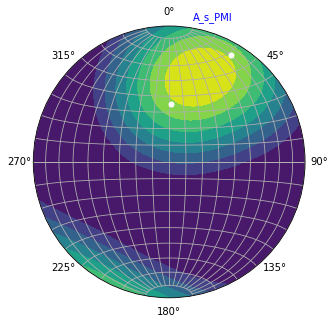

----------------------------------------------------------------------------------------------------------------------
A_b_PRK observations n= 1


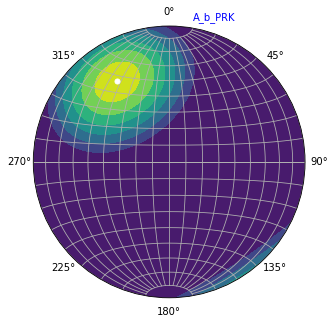

----------------------------------------------------------------------------------------------------------------------
Wyloo_Group
P__WYa_st observations n= 1
P__WYd_kd observations n= 1
P__WYm_sp observations n= 1


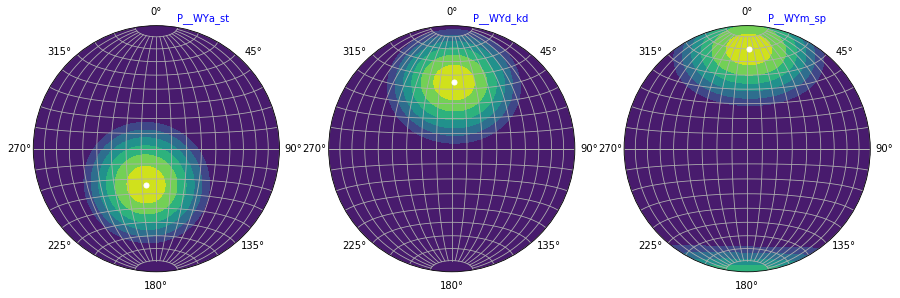

----------------------------------------------------------------------------------------------------------------------
Shingle_Creek_Group
P__SKq_stq observations n= 5
P__SKb_bb observations n= 0


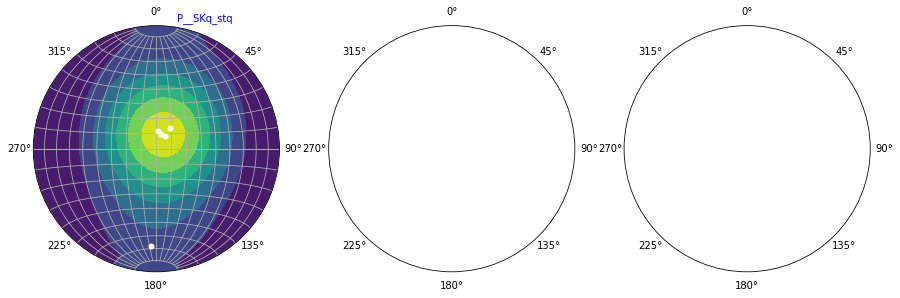

----------------------------------------------------------------------------------------------------------------------
Turee_Creek_Group
P__TKa_xs_k observations n= 0
P__TKo_stq observations n= 0
P__TKk_sf observations n= 3
P__TK_s observations n= 2


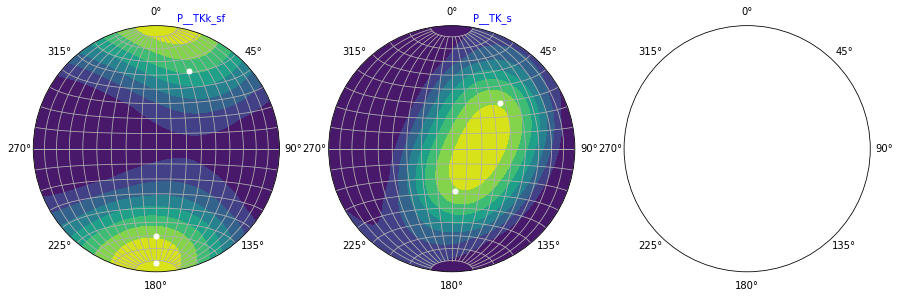

----------------------------------------------------------------------------------------------------------------------
Hamersley_Group
P__HAo_ci observations n= 1
P__HAw_fr observations n= 0
P__HAj_xci_od observations n= 3
P__HAb_cib observations n= 16


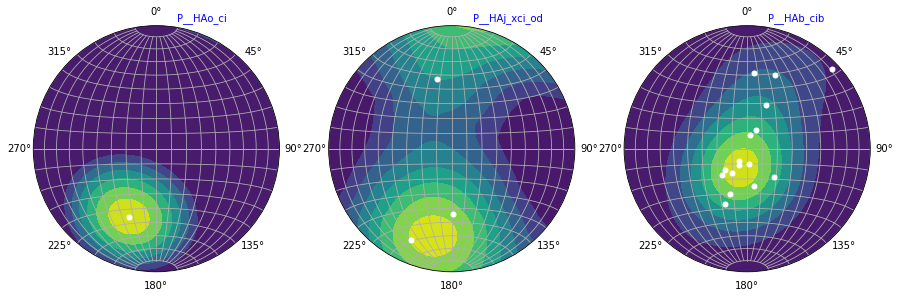

A_HAS_xsl_ci observations n= 6
A_HAd_kd observations n= 3
A_HAm_cib observations n= 13


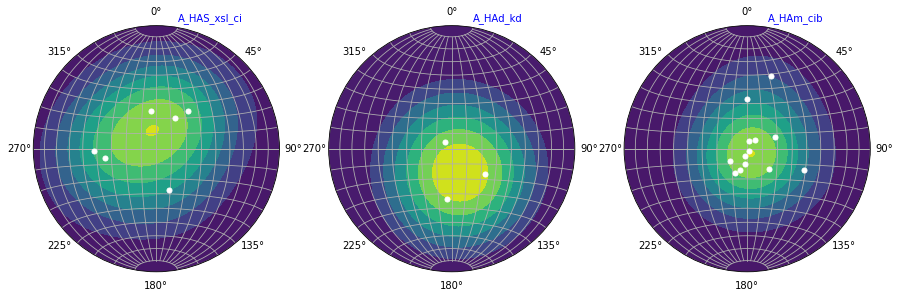

----------------------------------------------------------------------------------------------------------------------
Fortescue_Group
A_FOj_xs_b observations n= 21
A_FO_xo_a observations n= 0
A_FO_od observations n= 0
A_FOu_bbo observations n= 9
A_FOp_bs observations n= 7


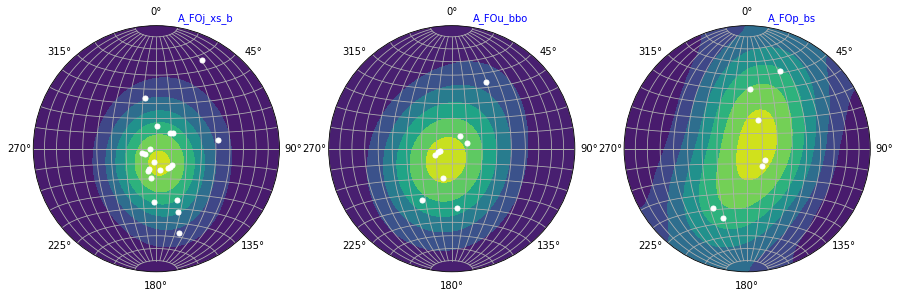

A_FOo_bbo observations n= 0
A_FOh_xs_f observations n= 20
A_FOr_b observations n= 0


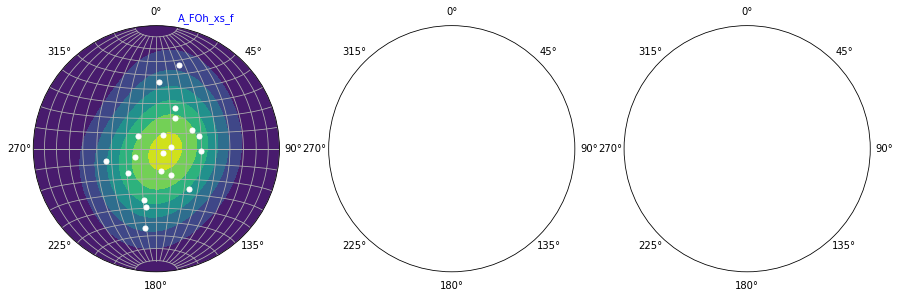

----------------------------------------------------------------------------------------------------------------------
A_s_PMI
A_s_PMI observations n= 2


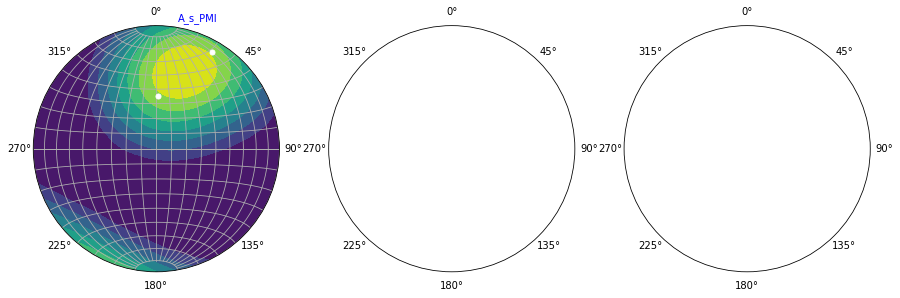

----------------------------------------------------------------------------------------------------------------------
A_mgn_PMI
A_mgn_PMI observations n= 0
----------------------------------------------------------------------------------------------------------------------
A_mgn_PRK
A_mgn_PRK observations n= 0
----------------------------------------------------------------------------------------------------------------------
A_s_PRK
A_s_PRK observations n= 0
----------------------------------------------------------------------------------------------------------------------
A_b_PRK
A_b_PRK observations n= 1


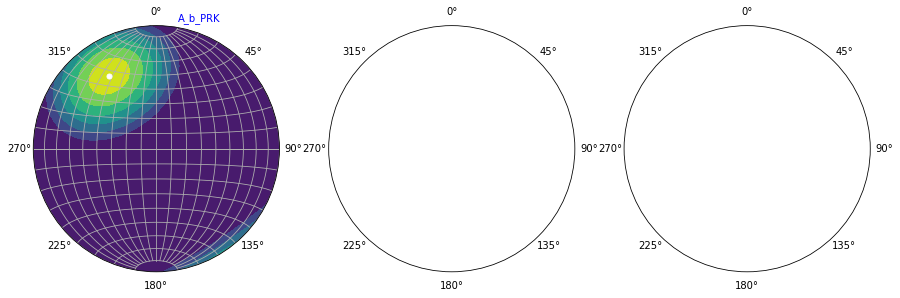

In [49]:
orientations=pd.read_csv(output_path+'orientations.csv',",")
all_sorts=pd.read_csv(tmp_path+'all_sorts.csv',",")
            
m2l_utils.plot_bedding_stereonets(orientations,all_sorts)


## 3b Find those series that don't have any orientation or contact point data  then create arbitrary point for series with no orientation data
Not sure if gempy needs this but geomodeller does. Currently just gives a point dipping 45 degrees to North, but could use dip direction normal to basal surface)

In [ ]:
m2l_geometry.create_orientations( tmp_path, output_path, dtm,dtb,dtb_null,cover_map,geol_clip,structure_clip,c_l)

## 4a Export contact information subset of each polygon to gempy format
mj: Orientation data needs calculated height as file does not provide it, taken from SRTM data already downloaded. Need to reduce number of points whilst retaining useful info (Ranee's job!)'
To calculate which are the basal units contact for a polygon find the polygons which are older than the selected polygon, in the example below the central polygon has relative age 23 so its basal contact is with the polygons whose ages are 26 & 28. If there are no older units for a polygon it has no basal content. We keep every nth node based on the decimate term (simple count along polyline). gempy seems to need at least two points per surface, so we always take the first two points.


<img src='../graphics/base.png'>

In [ ]:
ls_dict,ls_dict_decimate=m2l_geometry.save_basal_contacts(tmp_path,dtm,dtb,dtb_null,cover_map,geol_clip,contact_decimate,c_l,intrusion_mode)

## 4b Remove all basal contacts that are defined by faults and save to shapefile (no decimation)

In [ ]:
display(ls_dict)

In [ ]:
m2l_geometry.save_basal_no_faults(tmp_path+'basal_contacts.shp',tmp_path+'faults_clip.shp',ls_dict,10,c_l,dst_crs)

## 4c Remove faults from decimated basal contacts as save as csv file

In [ ]:
contacts=gpd.read_file(tmp_path+'basal_contacts.shp')

m2l_geometry.save_basal_contacts_csv(contacts,output_path,dtm,dtb,dtb_null,cover_map,contact_decimate,c_l)

m2l_utils.plot_points(output_path+'contacts4.csv',geol_clip, 'formation','X','Y',True)
#m2l_geometry.save_contacts_with_faults_removed(tmp_path+'faults_clip.shp',output_path,10,ls_dict,ls_dict_decimate,c_l,dst_crs,dtm)

## 4d Process fault geometry
Save Faults as decimated points and representative orientation  
Then, for each  fault string:
- incementally advance along polyline every at each inter-node (no point in doing more?)
- find local stratigraphy 10m to left and right of fault
  
Once full fault has been traversed:
- Find list of contacts left 
- Find equivalent contacts on right
- use interpolated orientations to estimate minimum true offset assuming vertical displacement and store 
- if no equivalent found, flag as domain fault and find min strat offset for contact, use cumulative minimum thickness estimate and store with flag (not implemented)
- estimate median & sd of minimum fault offset and store with flag (not implemented)

Local Orientations
Since much of the code is the same, we benefit by calculating local orientation data either side of fault so that geomodeller/gempy have satisfied fault compartment orientation data## Save fault as contact info and and orientation info make vertical (for the moment)

In [ ]:
m2l_geometry.save_faults(tmp_path+'faults_clip.shp',output_path,dtm,dtb,dtb_null,cover_map,c_l,fault_decimate,min_fault_length,fault_dip)

use_gcode=('Hamersley Group','Fortescue Group','Wyloo Group','Shingle Creek Group','Turee Creek Group' ) 
use_gcode2=('Hamersley_Group','Fortescue_Group','Wyloo_Group','Shingle_Creek_Group','Turee_Creek_Group' ) 

m2l_interpolation.process_fault_throw_and_near_orientations(tmp_path,output_path,dtm_reproj_file,dtb,dtb_null,cover_map,c_l,use_gcode,use_gcode2,dst_crs,bbox,scheme)

In [ ]:
m2l_utils.plot_points(output_path+'fault_displacements3.csv',geol_clip, 'apparent_displacement','X','Y',False)

## 4e Process plutons

For each instruve but not sill polygon, find older neighbours and store decimated contact points. Also store dipping contact orientations (user defined, just because) with four possible sub-surface configurations:

<b>saucers: \\_+++_/ <br>
batholiths: +++/__ __ _\\+++  <br> 
domes: /‾+++‾\\ <br>
pendants: +++\\_  _/+++ <br>
</b>
  
Saves out orientations and contact points, as well as updated group level stratigraphic column.<br>


In [ ]:
bbox=(minx,miny,maxx,maxy)

pluton_dip=str(pluton_dip)

dist_buffer=10
dtm = rasterio.open(dtm_reproj_file)
m2l_geometry.process_plutons(tmp_path,output_path,geol_clip,local_paths,dtm,dtb,dtb_null,cover_map,pluton_form,pluton_dip,contact_decimate,c_l)


## 5a Interpolates a regular grid of orientations from an  shapefile of arbitrarily-located points and saves out four csv files of l,m & n direction cosines and dip dip direction data

Can choose between various RBF and IDW options   
  
The purpose of these interpolations and associated code is to help in three cases:
- Providing estimated dips and contacts in fault-bounded domains where no structural data are available
- Needed to estimate true thickness of formations
- Possibly useful for poulating parts of maps where little structural data is available

In [ ]:
use_gcode=('Hamersley Group','Fortescue Group','Wyloo Group','Shingle Creek Group','Turee Creek Group' ) ################# MOVE UP   #########################
structure_file=tmp_path+'structure_clip.shp'
bbox=(minx+inset,miny+inset,maxx-inset,maxy-inset)

In [ ]:
print(c_l['g'])
print(use_gcode)

In [ ]:
m2l_interpolation.interpolate_orientations(structure_file,tmp_path,bbox,c_l,use_gcode,scheme,gridx,gridy,False)

## 5b Interpolates a regular grid from a shapefile of from contacts and saves out three csv files of l & m direction cosines and strike data

Can choose between various RBF and IDW options  

<font face color='red'>Best with basal contacts only, using Notebook #1 as this avoids intrusive  and fault contacts being considered</font>

In [ ]:
geology_file=tmp_path+'basal_contacts.shp'

dtm = rasterio.open(dtm_reproj_file)
use_gcode=('Hamersley_Group','Fortescue_Group','Wyloo_Group','Shingle_Creek_Group','Turee_Creek_Group' ) ################# MOVE UP   #########################


In [ ]:
contact_decimate=2
null_scheme='null'

m2l_interpolation.save_contact_vectors(geology_file,tmp_path,dtm,dtb,dtb_null,cover_map,bbox,c_l,null_scheme,contact_decimate)

m2l_interpolation.interpolate_contacts(geology_file,tmp_path,dtm,dtb,dtb_null,cover_map,bbox,c_l,use_gcode,scheme,gridx,gridy,False)


## 5c Combines rbf of contact orientations with rbf of dip/dipdir measurements

Uses normalised direction cosines **(l,m,n)**:  
- **l,m** from RBF of basal contact orientations  
- **signs of l & m** from misorientation with RBF of orientation data and  
- **n** from RBF of orientation data  
  
May be useful for adding data where no orientations are available (e.g. in fault bounded domains) and for calculating true thickness of layers. Assumes a 2D plane of data, but if 3D RBF was calulated and projected contact info was used it should apply with topography too. 

In [ ]:
geology_file=tmp_path+'geol_clip.shp'
combo_file=tmp_path+'combo.csv'

lc=np.loadtxt(tmp_path+'interpolation_contacts_l.csv',skiprows =1,delimiter =',',dtype=float)
mc=np.loadtxt(tmp_path+'interpolation_contacts_m.csv',skiprows =1,delimiter =',',dtype=float)
lo=np.loadtxt(tmp_path+'interpolation_l.csv',skiprows =1,delimiter =',',dtype=float)
mo=np.loadtxt(tmp_path+'interpolation_m.csv',skiprows =1,delimiter =',',dtype=float)
no=np.loadtxt(tmp_path+'interpolation_n.csv',skiprows =1,delimiter =',',dtype=float)
xy=np.loadtxt(tmp_path+'interpolation_'+scheme+'.csv',skiprows =1,delimiter =',',dtype=float)

In [ ]:
m2l_interpolation.join_contacts_and_orientations(combo_file,geology_file,tmp_path,dtm_reproj_file,dtb,dtb_null,cover_map,c_l,lo,mo,no,lc,mc,xy,dst_crs,bbox,False)


## 5d Estimate formation thickness and normalised formation thickness

In [ ]:
buffer =5000
max_thickness_allowed=10000

m2l_geometry.calc_thickness(tmp_path,output_path,buffer,max_thickness_allowed,c_l)

m2l_geometry.normalise_thickness(output_path)

In [ ]:
    
m2l_utils.plot_points(output_path+'formation_thicknesses_norm.csv',geol_clip,'norm_th','x','y',False)



## 5e Creates fold axial trace points

In [ ]:
m2l_geometry.save_fold_axial_traces(tmp_path+'folds_clip.shp',output_path,dtm,dtb,dtb_null,cover_map,c_l,fold_decimate)

#Save fold axial trace near-hinge orientations
fat_step=750         # how much to step out normal to fold axial trace
close_dip=20.0       #dip to assign to all new orientations
   
m2l_geometry.save_fold_axial_traces_orientations(tmp_path+'folds_clip.shp',output_path,tmp_path,dtm,dtb,dtb_null,cover_map,c_l,dst_crs,fold_decimate,fat_step,close_dip,scheme)


## 6a Preprocess data to ensure it meets modelling requirements

In [ ]:
if(local_paths): ###############FUDGE#############
    use_gcode=('Hamersley_Group','Fortescue_Group','Turee_Creek_Group','A_mgn_PRK',  'A_mgn_PMI' ) ################# MOVE UP   #########################
    #use_gcode=('Hamersley_Group','Fortescue_Group','Wyloo_Group','Shingle_Creek_Group','Turee_Creek_Group','A_mgn_PRK',  'A_mgn_PMI' ) ################# MOVE UP   #########################
else:
    use_gcode=('Hamersley_Group','Fortescue_Group','Wyloo_Group','Shingle_Creek_Group','Turee_Creek_Group','A_mgn_PMI',  'A_mgn_PRK' ) ################# MOVE UP   #########################


print('only processing',use_gcode)

#inputs=('invented_orientations','interpolated_orientations','intrusive_orientations','fat_orientations','near_fault_orientations')
#inputs=('invented_orientations','interpolated_orientations','intrusive_orientations','fat_orientations','near_fault_orientations')
inputs=('invented_orientations','fat_orientations')
#inputs=('invented_orientations')

m2l_geometry.tidy_data(output_path,tmp_path,use_gcode,use_interpolations,use_fat,pluton_form,inputs,workflow)

## 6b Calculate polarity of original bedding orientation data (not used yet in final calc)

In [ ]:
m2l_geometry.save_orientations_with_polarity(output_path+'orientations.csv',output_path,c_l,tmp_path+'basal_contacts.shp',tmp_path+'all_sorts.csv',)

m2l_utils.plot_points(output_path+'orientations_polarity.csv',geol_clip,'polarity','X','Y',True)


## 6c Calculate minimum fault offset from stratigraphy and stratigraphic fault offset

In [ ]:
m2l_geometry.fault_strat_offset(output_path,c_l,dst_crs,output_path+'formation_summary_thicknesses.csv', tmp_path+'all_sorts.csv',tmp_path+'faults_clip.shp',tmp_path+'geol_clip.shp',output_path+'fault_dimensions.csv')


m2l_utils.plot_points(output_path+'fault_strat_offset3.csv',geol_clip,'min_offset','X','Y',True)
m2l_utils.plot_points(output_path+'fault_strat_offset3.csv',geol_clip,'strat_offset','X','Y',True)


## 6d Calculate igneous intrusion polarity (local age gradient) information

Not sure if this is working...

In [ ]:
from shapely.geometry import shape, Polygon, LineString, Point
from math import sin, cos, atan, atan2, asin, radians, degrees, sqrt, pow, acos, fabs, tan, fmod

def process_plutons_polarity(tmp_path,output_path,geol_clip,local_paths,dtm,pluton_form,pluton_dip,contact_decimate,c_l, calc_lag):
    
    groups=np.genfromtxt(tmp_path+'groups.csv',delimiter=',',dtype='U25')
    ngroups=len(groups[0])-1

    orig_ngroups=ngroups

    gp_ages=np.zeros((1000,3))
    gp_names=np.zeros((1000),dtype='U25')

    for i in range (0,ngroups):
        gp_ages[i,0]=-1e6 # group max_age
        gp_ages[i,1]=1e6 # group min_age
        gp_ages[i,2]=i # group index
        gp_names[i]=groups[0][i+1].replace("\n","")
        #print(i,gp_names[i])

    #print(local_paths)  

    allc=open(output_path+'all_ign_contacts.csv',"w")
    allc.write('GROUP_,id,x,y,z,code\n')
    ac=open(output_path+'ign_contacts.csv',"w")
    ac.write("X,Y,Z,formation\n")
    ao=open(output_path+'ign_orientations_'+pluton_form+'.csv',"w")
    ao.write("X,Y,Z,azimuth,dip,polarity,formation\n")
    if(calc_lag==True):
        ap=open(output_path+'ign_lag.csv',"w")
        ap.write("X,Y,Z,azimuth,formation\n")
    #print(output_path+'ign_orientations_'+pluton_form+'.csv')
    j=0
    allpts=0
    ls_dict={}
    ls_dict_decimate={}
    id=0
    for ageol in geol_clip.iterrows(): 
        ades=str(ageol[1][c_l['ds']])
        arck=str(ageol[1][c_l['r1']])
        if(str(ageol[1][c_l['g']])=='None'):
            agroup=str(ageol[1][c_l['c']])
        else:
            agroup=str(ageol[1][c_l['g']])
        
        for i in range(0,ngroups):
            if (gp_names[i]==agroup):
                if(int(ageol[1][c_l['max']]) > gp_ages[i][0]  ):
                    gp_ages[i][0] = ageol[1][c_l['max']]
                if(int(ageol[1][c_l['min']]) < gp_ages[i][1]  ):
                    gp_ages[i][1] = ageol[1][c_l['min']]
        if(c_l['intrusive'] in arck and c_l['sill'] not in ades):
            newgp=str(ageol[1][c_l['c']])
            #print(newgp)
            if(str(ageol[1][c_l['g']])=='None'):
                agp=str(ageol[1][c_l['c']])
            else:
                agp=str(ageol[1][c_l['g']])

            if(not newgp  in gp_names):
                gp_names[ngroups]=newgp
                gp_ages[ngroups][0]=ageol[1][c_l['max']]
                gp_ages[ngroups][1]=ageol[1][c_l['min']]
                gp_ages[ngroups][2]=ngroups
                ngroups=ngroups+1
                
            neighbours=[]
            j+=1
            central_age=ageol[1][c_l['min']]    #absolute age of central polygon
            central_poly=ageol[1].geometry
            for bgeol in geol_clip.iterrows(): #potential neighbouring polygons  
                if(ageol[1].geometry!=bgeol[1].geometry): #do not compare with self
                    if (ageol[1].geometry.intersects(bgeol[1].geometry)): # is a neighbour
                        neighbours.append([(bgeol[1][c_l['c']],bgeol[1][c_l['min']],bgeol[1][c_l['r1']],bgeol[1][c_l['ds']],bgeol[1].geometry)])  
            #display(neighbours)
            if(len(neighbours) >0):
                for i in range (0,len(neighbours)):
                    if((c_l['intrusive'] in neighbours[i][0][2] and c_l['sill'] not in ades) 
                       #or ('intrusive' not in neighbours[i][0][2]) and neighbours[i][0][1] > central_age ): # neighbour is older than central
                       or (c_l['intrusive'] not in neighbours[i][0][2]) and neighbours[i][0][1]  ): # neighbour is older than central
                        older_polygon=neighbours[i][0][4]
                        if(not central_poly.is_valid ):
                            central_poly = central_poly.buffer(0)
                        if(not older_polygon.is_valid):
                            older_polygon = older_polygon.buffer(0)
                        LineStringC = central_poly.intersection(older_polygon)
                        if(LineStringC.wkt.split(" ")[0]=='GEOMETRYCOLLECTION' or 
                           LineStringC.wkt.split(" ")[0]=='MULTIPOLYGON' or
                           LineStringC.wkt.split(" ")[0]=='POLYGON'): #ignore polygon intersections for now, worry about them later!
                            #print("debug:GC,MP,P")
                            continue

                        elif(LineStringC.wkt.split(" ")[0]=='MULTILINESTRING'):
                            k=0
                            ls_dict[id] = {"id": id,c_l['c']:newgp,c_l['g']:newgp, "geometry": LineStringC}
                            id=id+1
                            for lineC in LineStringC: #process all linestrings
                                if(m2l_utils.mod_safe(k,contact_decimate)==0 or k==int((len(LineStringC)-1)/2) or k==len(LineStringC)-1): #decimate to reduce number of points, but also take second and third point of a series to keep gempy happy
                                    locations=[(lineC.coords[0][0],lineC.coords[0][1])] #doesn't like point right on edge?
                                    if(lineC.coords[0][0] > dtm.bounds[0] and lineC.coords[0][0] < dtm.bounds[2] and  
                                       lineC.coords[0][1] > dtm.bounds[1] and lineC.coords[0][1] < dtm.bounds[3]):       
                                            height=m2l_utils.value_from_raster(dtm,locations)
                                            ostr=str(lineC.coords[0][0])+","+str(lineC.coords[0][1])+","+height+","+newgp.replace(" ","_").replace("-","_")+"\n"
                                            ac.write(ostr)
                                            allc.write(agp+","+str(ageol[1][c_l['o']])+","+ostr)
                                            ls_dict_decimate[allpts] = {"id": allpts,c_l['c']:newgp,c_l['g']:newgp, "geometry": Point(lineC.coords[0][0],lineC.coords[0][1])}
                                            allpts+=1 
                                    else:
                                        continue
                                else:
                                    if(lineC.coords[0][0] > dtm.bounds[0] and lineC.coords[0][0] < dtm.bounds[2] and  
                                            lineC.coords[0][1] > dtm.bounds[1] and lineC.coords[0][1] < dtm.bounds[3]):       
                                        height=m2l_utils.value_from_raster(dtm,locations)
                                        ostr=str(lineC.coords[0][0])+","+str(lineC.coords[0][1])+","+height+","+newgp.replace(" ","_").replace("-","_")+"\n"
                                        #ls_dict_decimate[allpts] = {"id": id,"CODE":ageol[1]['CODE'],"GROUP_":ageol[1]['GROUP_'], "geometry": Point(lineC.coords[0][0],lineC.coords[0][1])}
                                        allc.write(agp+","+str(ageol[1][c_l['o']])+","+ostr)
                                        allpts+=1
                                
                                if(m2l_utils.mod_safe(k,contact_decimate)==0 or k==int((len(LineStringC)-1)/2) or k==len(LineStringC)-1): #decimate to reduce number of points, but also take second and third point of a series to keep gempy happy
                                    dlsx=lineC.coords[0][0]-lineC.coords[1][0]
                                    dlsy=lineC.coords[0][1]-lineC.coords[1][1]
                                    lsx=dlsx/sqrt((dlsx*dlsx)+(dlsy*dlsy))
                                    lsy=dlsy/sqrt((dlsx*dlsx)+(dlsy*dlsy))                                        

                                    locations=[(lineC.coords[0][0],lineC.coords[0][1])]
                                    height= m2l_utils.value_from_raster(dtm,locations)
                                    azimuth=(180+degrees(atan2(lsy,-lsx)))%360 #normal to line segment
                                    testpx=lineC.coords[0][0]+lsy # pt just a bit in/out from line
                                    testpy=lineC.coords[0][0]+lsx

                                    for cgeol in geol_clip.iterrows(): # check on direction to dip
                                        if LineString(central_poly.exterior.coords).contains(Point(testpx, testpy)):
                                            azimuth=(azimuth-180)%360
                                            break
                                    if(pluton_form=='saucers'):
                                        ostr=str(lineC.coords[0][0])+","+str(lineC.coords[0][1])+","+str(height)+","+str(azimuth)+","+str(pluton_dip)+",1,"+newgp.replace(" ","_").replace("-","_")+"\n"
                                    elif(pluton_form=='domes'):
                                        azimuth=(azimuth-180)%360
                                        ostr=str(lineC.coords[0][0])+","+str(lineC.coords[0][1])+","+str(height)+","+str(azimuth)+","+str(pluton_dip)+",0,"+newgp.replace(" ","_").replace("-","_")+"\n"
                                    elif(pluton_form=='pendant'):
                                        ostr=str(lineC.coords[0][0])+","+str(lineC.coords[0][1])+","+str(height)+","+str(azimuth)+","+str(pluton_dip)+",0,"+newgp.replace(" ","_").replace("-","_")+"\n"
                                    else: #pluton_form == batholith
                                        azimuth=(azimuth-180)%360
                                        ostr=str(lineC.coords[0][0])+","+str(lineC.coords[0][1])+","+str(height)+","+str(azimuth)+","+str(pluton_dip)+",1,"+newgp.replace(" ","_").replace("-","_")+"\n"
                                                                            
                                    ao.write(ostr)
                                    
                                    if(calc_lag==True):                                    
                                        ostr=str(lineC.coords[0][0]+lsx)+","+str(lineC.coords[0][1]+lsy)+","+str(height)+","+str((azimuth+180)%360)+","+newgp.replace(" ","_").replace("-","_")+"\n"
                                        ap.write(ostr)

                                k+=1
                        elif(LineStringC.wkt.split(" ")[0]=='LINESTRING'): # apparently this is not needed
                            #print("debug:LINESTRING")
                            k=0
                            for pt in LineStringC.coords: #process one linestring
                                k+=1
                        elif(LineStringC.wkt.split(" ")[0]=='POINT'): # apparently this is not needed
                            #print("debug:POINT")
                            k+=1
                        else:
                            #print(LineStringC.wkt.split(" ")[0]) # apparently this is not needed
                            k+=1
    ac.close()
    ao.close()
    if(calc_lag==True):
        ap.close()
    allc.close()

      
    an=open(tmp_path+'groups2.csv',"w")

    for i in range (0,orig_ngroups):
        print(i,gp_names[i].replace(" ","_").replace("-","_"))
        an.write(gp_names[i].replace(" ","_").replace("-","_")+'\n')
    an.close()

    all_sorts=pd.read_csv(tmp_path+'all_sorts.csv',",")

    as_2=open(tmp_path+'all_sorts.csv',"r")
    contents =as_2.readlines()
    as_2.close

    all_sorts_file=open(tmp_path+'all_sorts2.csv',"w")
    all_sorts_file.write('index,group number,index in group,number in group,code,group\n')
    j=1

    for i in range(1,len(all_sorts)+1):    
        all_sorts_file.write(contents[i]) #don't write out if already there in new groups list#
        
    all_sorts_file.close()
    print('pluton contacts and orientations saved as:')
    print(output_path+'ign_contacts.csv')
    print(output_path+'ign_orientations_'+pluton_form+'.csv')
    if(calc_lag==True):
        print(output_path+'ign_lag.csv')
process_plutons_polarity(tmp_path,output_path,geol_clip,local_paths,dtm,pluton_form,pluton_dip,contact_decimate,c_l,True)

## 6e Save near contact  polarity (local age gradient)
This kind of works if the orientations are close to contacts, but will indicate reverse polarity if orietnations are associated with second order fold limbs in a larger fold (which is also useful to know and may solve problem of how to thin orientation data when you have parasitic folds, but is more related to vergence than polarity). At the moment these two cases are mixed up...

In [ ]:
def save_basal_contact_polarity(path_in,dtm,geol_clip,contact_decimate,c_l,intrusion_mode, calc_lag):
    #print("decimation: 1 /",contact_decimate)
    plist=[]
    i=0
    all_geom=m2l_utils.explode(geol_clip)


    for ageol in all_geom.iterrows(): # central polygon
        all_coords=m2l_geometry.extract_poly_coords(ageol[1].geometry,0)
        plist+=(i,list(all_coords['exterior_coords']),ageol[1][c_l['c']],ageol[1][c_l['ds']],ageol[1][c_l['g']],ageol[1][c_l['r1']],ageol[1][c_l['o']])
        i=i+1
        for j in range(0,len(all_coords['interior_coords']),2):
            plist+=(i,list(all_coords['interior_coords'][j+1]),ageol[1][c_l['c']],ageol[1][c_l['ds']],ageol[1][c_l['g']],ageol[1][c_l['r1']],ageol[1][c_l['o']])
            i=i+1
               
    #dataset = rasterio.open(path_in+'/dtm_rp.tif')
    ag=open(path_in+'/all_sorts.csv',"r")
    contents =ag.readlines()
    ag.close
    #print("surfaces:",len(contents))
    #print("polygons:",len(all_geom))
    ulist=[]
    for i in range(1,len(contents)):
        #print(contents[i].replace("\n",""))
        cont_list=contents[i].split(",")
        ulist.append([i, cont_list[4].replace("\n","")])
    #print(ulist)

    allc=open(path_in+'/all_contacts.csv',"w")
    allc.write('GROUP_,id,x,y,z,code\n')
    ac=open(path_in+'/contacts.csv',"w")
    ac.write("X,Y,Z,formation\n")
    #print(dtm.bounds)
    j=0
    allpts=0
    deci_points=0
    ls_dict={}
    ls_dict_decimate={}
    id=0
    #print(len(plist))
    for a_poly in range(0,len(plist),7):
        if( not 'intrusive' in plist[a_poly+5]):
            a_polygon=Polygon(plist[a_poly+1])
            agp=str(plist[a_poly+4])
            if(agp=='None'):
                agp=plist[a_poly+2].replace(" ","_").replace("-","_")

            neighbours=[]
            j+=1
            out=[item for item in ulist if plist[a_poly+2].replace(" ","_").replace("-","_") in item]
            if(len(out)>0):
                central=out[0][0]    #relative age of central polygon

                for b_poly in range(0,len(plist),7):
                    b_polygon=LineString(plist[b_poly+1])

                    if(plist[a_poly] != plist[b_poly]): #do not compare with self

                        if (a_polygon.intersects(b_polygon)) : # is a neighbour, but not a sill
                            if(  (not c_l['sill'] in plist[b_poly+3] or not c_l['intrusive'] in plist[b_poly+5]) and intrusion_mode==0): #intrusion_mode=0 (sills only excluded)
                                 neighbours.append((b_poly))                               
                            elif((not c_l['intrusive'] in plist[b_poly+5])  and intrusion_mode==1): #intrusion_mode=1 (all intrusions  excluded)
                                 neighbours.append((b_poly))                               


                if(len(neighbours) >0):
                    for i in range (0,len(neighbours)):
                        b_polygon=LineString(plist[neighbours[i]+1])

                        out=[item for item in ulist if plist[neighbours[i]+2].replace(" ","_").replace("-","_")  in item]

                        if(len(out)>0):
                            #if(out[0][0] > central and out[0][0] < youngest_older): # neighbour is older than central, and younger than previous candidate
                            if(out[0][0] > central  ): # neighbour is older than central

                                if(not a_polygon.is_valid ):
                                    a_polygon = a_polygon.buffer(0)
                                if(not b_polygon.is_valid):
                                    b_polygon = b_polygon.buffer(0)                                    
                                LineStringC = a_polygon.intersection(b_polygon)

                                if(LineStringC.wkt.split(" ")[0]=='GEOMETRYCOLLECTION' ): #ignore weird intersections for now, worry about them later!
                                    #print("debug:GC")
                                    continue
                                elif(LineStringC.wkt.split(" ")[0]=='MULTIPOLYGON' or
                                     LineStringC.wkt.split(" ")[0]=='POLYGON'):
                                         print("debug:MP,P",ageol[1][c_l['c']])

                                elif(LineStringC.wkt.split(" ")[0]=='MULTILINESTRING'):
                                    k=0

                                    if(str(plist[a_poly+4])=='None'):
                                        ls_dict[id] = {"id": id,c_l['c']:plist[a_poly+2].replace(" ","_").replace("-","_"),c_l['g']:plist[a_poly+2].replace(" ","_").replace("-","_"), "geometry": LineStringC}
                                    else:
                                        ls_dict[id] = {"id": id,c_l['c']:plist[a_poly+2].replace(" ","_").replace("-","_"),c_l['g']:plist[a_poly+4].replace(" ","_").replace("-","_"), "geometry": LineStringC}
                                    id=id+1
                                    for lineC in LineStringC: #process all linestrings
                                        if(m2l_utils.mod_safe(k,contact_decimate)==0 or k==int((len(LineStringC)-1)/2) or k==len(LineStringC)-1): #decimate to reduce number of points, but also take second and third point of a series to keep gempy happy
                                            locations=[(lineC.coords[0][0],lineC.coords[0][1])] #doesn't like point right on edge?
                                            if(lineC.coords[0][0] > dtm.bounds[0] and lineC.coords[0][0] < dtm.bounds[2] and  
                                               lineC.coords[0][1] > dtm.bounds[1] and lineC.coords[0][1] < dtm.bounds[3]):       
                                                    height=m2l_utils.value_from_raster(dtm,locations)
                                                    ostr=str(lineC.coords[0][0])+","+str(lineC.coords[0][1])+","+height+","+str(plist[a_poly+2].replace(" ","_").replace("-","_"))+"\n"
                                                    ac.write(ostr)
                                                    allc.write(agp+","+str(ageol[1][c_l['o']])+","+ostr)
                                                    if(str(plist[a_poly+4])=='None'):
                                                        ls_dict_decimate[deci_points] = {"id": allpts,c_l['c']:plist[a_poly+2].replace(" ","_").replace("-","_"),c_l['g']:plist[a_poly+2].replace(" ","_").replace("-","_"), "geometry": Point(lineC.coords[0][0],lineC.coords[0][1])}
                                                    else:
                                                        ls_dict_decimate[deci_points] = {"id": allpts,c_l['c']:plist[a_poly+2].replace(" ","_").replace("-","_"),c_l['g']:plist[a_poly+4].replace(" ","_").replace("-","_"), "geometry": Point(lineC.coords[0][0],lineC.coords[0][1])}
                                                    allpts+=1 
                                                    deci_points=deci_points+1
                                            else:
                                                continue
                                                #print("debug:edge points")
                                        else:
                                            locations=[(lineC.coords[0][0]+0.0000001,lineC.coords[0][1])] #doesn't like point right on edge?
                                            if(lineC.coords[0][0] > dtm.bounds[0] and lineC.coords[0][0] < dtm.bounds[2] and  
                                                lineC.coords[0][1] > dtm.bounds[1] and lineC.coords[0][1] < dtm.bounds[3]):       
                                                height=m2l_utils.value_from_raster(dtm,locations)
                                                ostr=str(lineC.coords[0][0])+","+str(lineC.coords[0][1])+","+height+","+str(plist[a_poly+2].replace(" ","_").replace("-","_"))+"\n"
                                                allc.write(agp+","+str(ageol[1][c_l['o']])+","+ostr)
                                                allpts+=1    
                                        k+=1
                                elif(LineStringC.wkt.split(" ")[0]=='LINESTRING'): # apparently this is not needed
                                    k=0
                                    for pt in LineStringC.coords: #process one linestring
                                        k+=1
                                elif(LineStringC.wkt.split(" ")[0]=='POINT'): # apparently this is not needed
                                    #print("debug:POINT")
                                    k=0
                                    k+=1
                                else:
                                    k=0
                                    k+=1


    ac.close()
    allc.close()
    print("basal contacts saved allpts=",allpts,"deci_pts=",deci_points)
    print("saved as",path_in+'all_contacts.csv',"and",path_in+'contacts.csv')
    return(ls_dict,ls_dict_decimate)

save_basal_contact_polarity(tmp_path,dtm,geol_clip,contact_decimate,c_l,intrusion_mode,True)

## 7a Analyse fault-fault topology

In [ ]:
m2l_topology.parse_fault_relationships(graph_path,tmp_path,output_path)

# loop2LoopStructural test 



In [ ]:
t1 = time.time()
import lavavu
from pyamg import solve

m2l_export.loop2LoopStructural(output_path+'formation_thicknesses.csv',output_path+'orientations.csv',output_path+'contacts4.csv',bbox)
t2 = time.time()

In [ ]:
print("m2l",(t1-t0)/60.0,"LoopStructural",(t2-t1)/60.0,"Total",(t2-t0)/60.0,"minutes")